In [221]:
import pandas as pd

In [222]:
harmonic = pd.read_parquet('../data/data_storage/harmonic_ou_parquets/train_harmonic.parquet')

In [223]:
import numpy as np
from PIL import Image, ImageDraw

def draw_line(data, size: int = 80) -> Image:
    '''
    Draws a line graph from the data and normalizes each column to sum to 255.

    Parameters:
    -----------
    data: array-like
        The data to be plotted. It should be a 1D array or list.
    size: int
        The side size of the image to be created. Default is 80.
    
    Returns:
    -----------
    Image
        A PIL Image object representing the line graph.
    '''

    if not hasattr(data, '__iter__'):
        raise ValueError("Input data must be an iterable (e.g., list, numpy array).")
    if len(data) == 0:
        raise ValueError("Input data cannot be empty.")
    if not isinstance(size, int) or size <= 0:
        raise ValueError("Size must be a positive integer.")
    
    data = np.array(data)

    if data.ndim != 1:
        raise ValueError("Input data must be a 1D array.")

    x_vals = np.linspace(0, size - 1, len(data))
    y_min, y_max = np.min(data), np.max(data)
    y_vals = (1 - (data - y_min) / (y_max - y_min)) * (size - 1)
    img = Image.new("L", (size, size), "black")
    draw = ImageDraw.Draw(img)

    for i in range(len(x_vals) - 1):
        x1, y1 = x_vals[i], y_vals[i]
        x2, y2 = x_vals[i + 1], y_vals[i + 1]
        draw.line((x1, y1, x2, y2), fill="white")
    
    arr = np.array(img)
    normalized_arr = np.uint8((arr / arr.sum(axis=0))*254) + 1

    normalized_img = Image.fromarray(normalized_arr, 'L')
    return normalized_img

In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageColumnKLDivLoss(nn.Module):
    def __init__(self, epsilon: float = 1e-10):
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Calculate KL divergence loss between columns of two image tensors.

        :param predicted: Tensor of shape (batch_size, 1, height, width)
        :param target: Tensor of shape (batch_size, 1, height, width)
        :return: scalar loss value
        """
        # ensure inputs are positive
        predicted = torch.clamp(predicted, min=0.0)
        target = torch.clamp(target, min=0.0)

        # add epsilon to inputs before normalization to ensure no zeros
        predicted = predicted + self.epsilon
        target = target + self.epsilon
        
        # ensure inputs are normalized
        pred_norm = predicted / predicted.sum(dim=1, keepdim=True)
        target_norm = target / target.sum(dim=1, keepdim=True)

        
        # calculate KL divergence for each column
        kl_div = F.kl_div(
            torch.log(pred_norm),  # input needs to be log-probabilities
            target_norm,      # target needs to be probabilities
            reduction='none'
        )
        
        # sum over height and width dimensions
        loss = kl_div.sum(dim=(1, 2)).mean()  # mean over batch size
        
        return loss

In [225]:
import numpy as np
from PIL import Image
from scipy.stats import entropy

def image_to_array(image: Image) -> np.ndarray:
    """Convert a PIL Image to a NumPy array."""
    return np.array(image) / 255.0

def calculate_loss(img1: Image, img2: Image) -> float:
    """Calculate the loss between two images using KL divergence."""
    if not isinstance(img1, Image.Image) or not isinstance(img2, Image.Image):
        raise ValueError("Both inputs must be PIL Image objects.")
    if img1.size != img2.size:
        raise ValueError("Images must have the same dimensions.")
    if img1.mode != 'L' or img2.mode != 'L':
        raise ValueError("Images must be in grayscale mode ('L').")
    
    arr1 = image_to_array(img1)
    arr1 = arr1 / arr1.sum(axis=0, keepdims=True)
    arr2 = image_to_array(img2)
    arr2 = arr2 / arr2.sum(axis=0, keepdims=True)

    l = 0.0

    for i in range(arr1.shape[1]):
        kl_div = entropy(arr2[:, i], arr1[:, i])
        l += kl_div
        
    return l

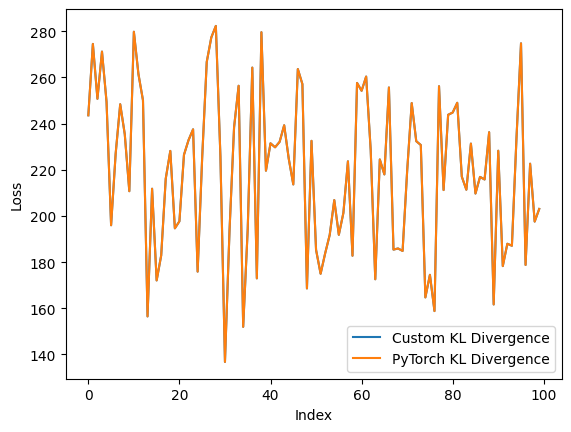

In [230]:
l = []
l_torch = []

for i in range(100):
    img1 = draw_line(harmonic.loc[i], 80)
    img2 = draw_line(harmonic.loc[i+1], 80)
    l += [calculate_loss(img1, img2)]
    X = torch.from_numpy(np.array([img1]))
    Y = torch.from_numpy(np.array([img2]))
    loss = ImageColumnKLDivLoss()
    l_torch += [(float(loss.forward(predicted = X, target = Y)))]

import matplotlib.pyplot as plt

plt.plot(l, label='Custom KL Divergence')
plt.plot(l_torch, label='PyTorch KL Divergence')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.legend()
plt.show()